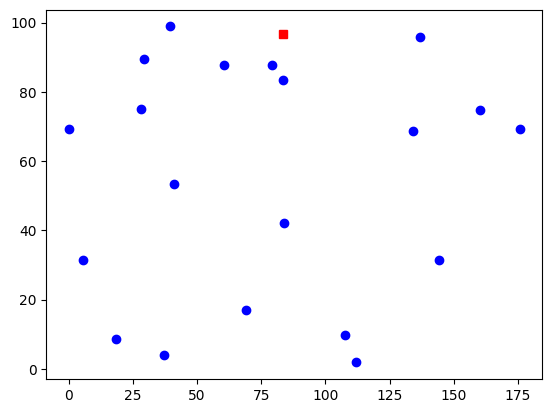

In [3]:
# Capacitated Vehicle Routing Problem with Gurobi (Heuristic, Nearest Neighbour presentation slide 26)
# The Gurobi Optimizer is a mathematical optimization software library for solving mixed-integer linear and quadratic optimization problems.
import numpy as np
import matplotlib.pyplot as plt

# Setting random seed
rnd = np.random
rnd.seed(1)

# Number of customers (excluding depot)
n = 20

# Generate random coordinates for depot and customers
xc = rnd.rand(n+1)*200 # x coordinates
yc = rnd.rand(n+1)*100 # y coordinates

# Plotting the depot and customers
plt.plot(xc[0], yc[0], c='r', marker='s') # Depot as a red square
plt.scatter(xc[1:], yc[1:], c='b') # Customers as blue dots

Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 30
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 80 rows, 440 columns and 840 nonzeros
Model fingerprint: 0x96ef1f15
Model has 380 general constraints
Variable types: 20 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
  GenCon rhs range [1e+00, 9e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 718 rows and 117 columns
Presolve time: 0.03s
Presolved: 798 rows, 557 columns, 3247 nonzeros
Variable types: 137 continuous, 420 integer (420 binary)
Found heuristic solution: objective 2743.6298303
Found heuristic solution: objective 2722.7469439
Found heuristic

C:\Users\dasc337\AppData\Local\Temp\ipykernel_35672\213886179.py:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', vehicles)


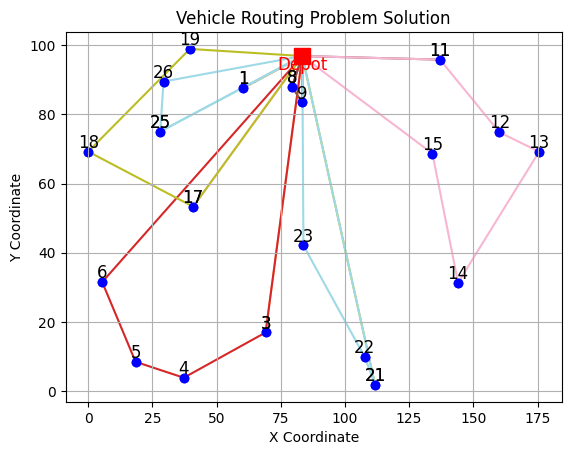

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum

# Setting random seed
rnd = np.random
rnd.seed(1)

# Number of customers (excluding depot)
n = 20

# Generate random coordinates for depot and customers
xc = rnd.rand(n+1)*200 # x coordinates
yc = rnd.rand(n+1)*100 # y coordinates

# Plotting the depot and customers
plt.plot(xc[0], yc[0], c='r', marker='s') # Depot as a red square
plt.scatter(xc[1:], yc[1:], c='b') # Customers as blue dots
# Same code as above for better comaprison


# Define set of nodes and vehicles
N = [i for i in range(1, n+1)] # Customers
V = [0] + N # Nodes (depot + customers)

# Define set of edges between nodes
A = [(i, j) for i in V for j in V if i != j]

# Calculate distance matrix using Euclidean distance
c = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in A}

# Define vehicle capacity and demand for each customer
Q = 20 # Vehicle capacity
q = {i: rnd.randint(1, 10) for i in N} # Demand of each customer

# Create a Gurobi model
mdl = Model('CVRP')

# Define decision variables
x = mdl.addVars(A, vtype=GRB.BINARY) # Binary decision variable indicating if edge (i, j) is used
u = mdl.addVars(N, vtype=GRB.CONTINUOUS) # Initializes continuous decision variable 

# Set objective function minimize total distance
mdl.modelSense = GRB.MINIMIZE
mdl.setObjective(quicksum(x[i, j] * c[i, j] for i, j in A))

# Add constraints
mdl.addConstrs(quicksum(x[i, j] for j in V if j != i) == 1 for i in N) # Each customer is visited exactly once
mdl.addConstrs(quicksum(x[i, j] for i in V if i != j) == 1 for j in N) # Each customer is departed from exactly once
mdl.addConstrs((x[i, j] == 1) >> (u[i] + q[j] == u[j]) for i, j in A if i != 0 and j != 0) # Flow constraint (not exceed capacity)
mdl.addConstrs(u[i] >= q[i] for i in N) # Ensure demand of each customer is met
mdl.addConstrs(u[i] <= Q for i in N) # Ensure vehicle capacity is not exceeded

# Set parameters and solve the model
mdl.Params.MIPGap = 0.1 # Allowable gap for MIP (Mixed Integer Programming) solutions
mdl.Params.TimeLimit = 30 # Time limit for optimization process (in seconds)
mdl.optimize() # Solve the model

# Extract active edges from the optimized solution
active_edges = [a for a in A if x[a].x > 0.99]

# Determine the visitation order for customers
visit_order = []
current_node = 0 # Start from the depot
vehicles = 0
vehicle_routes = []
route = []

# Construct routes from the solution
while active_edges:
    for i, (start, end) in enumerate(active_edges):
        if start == current_node:
            route.append((start, end))
            if current_node == 0:
                if route:
                    vehicle_routes.append(route)
                route = [(start, end)]
                vehicles += 1  # Count each new route starting from the depot as a new vehicle
            visit_order.append(end)
            current_node = end
            del active_edges[i]
            break

if route:
    vehicle_routes.append(route)

# Print the number of vehicles
print("Number of vehicles used:", vehicles)

# Colors for different routes
colors = plt.cm.get_cmap('tab20', vehicles)

# Plot the optimized route with visitation sequence numbers starting from 1 (exclude depot from numbering)
for vehicle_num, route in enumerate(vehicle_routes):
    color = colors(vehicle_num)
    for i, (start, end) in enumerate(route):
        plt.plot([xc[start], xc[end]], [yc[start], yc[end]], c=color, zorder=0)  # Colored lines for optimized routes
        # Annotate the node with the visitation sequence number starting from 1 for customers
        if end != 0:  # Skip the depot in numbering
            plt.text(xc[end], yc[end], str(visit_order.index(end) + 1), fontsize=12, ha='center', va='bottom', color='black')

# Annotate the depot separately
plt.text(xc[0], yc[0], 'Depot', fontsize=12, ha='center', va='top', color='red')

# Plotting the depot and customers
plt.plot(xc[0], yc[0], c='r', marker='s', markersize=12) # Depot
plt.scatter(xc[1:], yc[1:], c='b') # Customers

# Add labels and title
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Vehicle Routing Problem Solution")
plt.grid(True) # Add grid
plt.show() # Display the plot
